In [4]:
import sys
sys.path.append('/p/home/jusers/kotobi2/juwels/hida_project/')

In [5]:
import os.path as osp
import os

from attribution_gnn1.QM9_SpecData import QM9_SpecData
from attribution_gnn1.split import save_split
from attribution_gnn1.SpectraGNN import SpectraGNN
from attribution_gnn1.trainer import batch_train, batch_val
from attribution_gnn2.SpectraGAT import SpectraGAT



import numpy as np
import torch
from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', palette='muted', font_scale=1.5)

from pylab import rc, rcParams
rc('text', usetex=False)
rc('axes', linewidth=2) 
rc('font', weight='normal')

params = {'legend.fontsize': 15,
          'figure.figsize': (10, 8),}
rcParams.update(params)

In [6]:
num_epochs = 2000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'spectragnn_20k.pt'

# QM9_SpecData dataset class

In [42]:
root = '/p/home/jusers/kotobi2/juwels/data_qm9/qm9_spec_50k.pt'
qm9_spec = QM9_SpecData(root=root,
             raw_dir='/p/home/jusers/kotobi2/juwels/data_qm9/raw/',
             spectra=broadened_spectra_stk)

if not osp.exists(root):
    torch.save(qm9_spec, root)

  0%|          | 0/133885 [00:00<?, ?it/s]/p/home/jusers/kotobi2/juwels/hida_project/attribution_gnn1/QM9_SpecData.py:164: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrum = torch.tensor(self.spectra[i], dtype=torch.float)
[10:06:28] Warning: molecule is tagged as 3D, but all Z coords are zero
 37%|███▋      | 50000/133885 [00:25<00:43, 1944.89it/s]


# splitting the data

In [69]:
idxs = save_split(
    path='./data/split_files/qm9_split_50k.npz',
    ndata=len(qm9_spec),
    ntrain=40000,
    nval=6000,
    save_split=True,
    shuffle=True, 
    print_nsample=True
)

{'train': 40000, 'val': 6000, 'test': 4000}


In [ ]:
#train, val and test data
train_qm9 = qm9_spec[idxs['train']]
val_qm9 = qm9_spec[idxs['val']]
test_qm9 = qm9_spec[idxs['test']]

In [6]:
# data loaders 
train_loader = DataLoader(train_qm9, batch_size=100, shuffle=True)
val_loader = DataLoader(val_qm9, batch_size=100, shuffle=True)
test_loader = DataLoader(test_qm9, batch_size=100)

# SpectraGNN 

In [7]:
spectragnn = SpectraGNN(
    gnn_name='gatv2',
    in_channels=[11, 128, 256, 512],
    out_channels=[128, 256, 512, 600],
    num_targets=100,
    num_layers=4,
    heads=3
).to(device)

In [8]:
# loading the saved model 
path_to_saved_model = './best_model/spectragnn_20k.pt'
if osp.exists(path_to_saved_model):
    spectragnn.load_state_dict(torch.load(path_to_saved_model))
else:
    print('model is not loaded')


optimizer = torch.optim.AdamW(spectragnn.parameters(), lr=1e-4)
loss_fn = torch.nn.L1Loss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                                 milestones=np.arange(800, 6000, 500).tolist(),
                                                 gamma=0.8)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
 #                                                      factor=0.8,
  #                                                     patience=10)

model is not loaded


In [9]:
spectragnn

SpectraGNN(
  (interaction_layers): ModuleList(
    (0): GATv2Conv(11, 128, heads=3)
    (1): ReLU(inplace=True)
    (2): GATv2Conv(384, 256, heads=3)
    (3): ReLU(inplace=True)
    (4): GATv2Conv(768, 512, heads=3)
    (5): ReLU(inplace=True)
    (6): GATv2Conv(1536, 600, heads=1)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=600, out_features=100, bias=True)
)

# SpectraGAT

In [7]:
spectragat = SpectraGAT(
    node_features_dim=11,
    in_channels=[64, 128, 256, 512],
    out_channels=[128, 256, 512, 400],
    targets=100,
    n_layers=4,
    n_heads=3,
    use_residuals=True
).to(device)

In [8]:
# loading the saved model 
path_to_saved_model = './best_model/spectragat_20k.pt'
if osp.exists(path_to_saved_model):
    spectragat.load_state_dict(torch.load(path_to_saved_model))
else:
    print('model is not loaded')

optimizer = torch.optim.AdamW(spectragat.parameters(), lr=4e-4)
loss_fn = torch.nn.L1Loss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                                 milestones=np.arange(500, 5000, 500).tolist(),
                                                 gamma=0.8)

model is not loaded


In [9]:
spectragat

SpectraGAT(
  (pre_layer): LinearLayer(
    (linear): Linear(in_features=11, out_features=64, bias=False)
    (_activation): ReLU(inplace=True)
  )
  (res_block): Residual_block(
    (res_layers): Sequential(
      (0): LinearLayer(
        (linear): Linear(in_features=64, out_features=64, bias=False)
        (_activation): ReLU(inplace=True)
      )
      (1): LinearLayer(
        (linear): Linear(in_features=64, out_features=64, bias=False)
        (_activation): ReLU(inplace=True)
      )
      (2): LinearLayer(
        (linear): Linear(in_features=64, out_features=64, bias=False)
        (_activation): ReLU(inplace=True)
      )
    )
  )
  (gat_layers): ModuleList(
    (0): GATLayerCus(
      (lin_r): LinearLayer(
        (linear): Linear(in_features=64, out_features=384, bias=False)
        (_activation): Identity()
      )
      (lin_l): LinearLayer(
        (linear): Linear(in_features=64, out_features=384, bias=False)
        (_activation): Identity()
      )
      (res_block)

# Training

In [12]:
def loss_plot(epochs: int, 
              loss_values: dict, 
              ylabel: str = None,
              plot_test_loss: bool = False,
              save: bool = False
             ):
    assert isinstance(loss_values, dict)
    fig, ax = plt.subplots()
    sns.lineplot(epochs, loss_values['train'], ax=ax, label='train')
    if plot_test_loss:
        sns.lineplot(epochs, loss_values['validation'], ax=ax, label='validation') 
    ax.set_xlabel('Epochs')
    ax.set_ylabel('L1 loss')
    if save:
        fig.savefig('./train_test.png', dpi=200)

In [13]:
def save_model(model, model_name: str, 
               device: str):
    if not os.path.exists('./best_model'):
        os.mkdir('./best_model')
    path = os.path.join('./best_model', model_name)
    torch.save(model.cpu().state_dict(), path)
    model.to(device)

In [14]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

In [15]:
train_loss_values = []
val_loss_values = []
epochs = []
prev_loss = torch.tensor(float('inf'), device=device)

In [ ]:
start.record()
for epoch in range(num_epochs):
        train_avg_loss = batch_train(spectragnn, train_loader, optimizer, 
        loss_fn, scheduler, device)
        val_avg_loss = batch_val(spectragnn, val_loader, 
        loss_fn, device)

        if val_avg_loss < prev_loss:
            save_model(spectragnn, 
                       model_name, 
                       device)           
            prev_loss = val_avg_loss
        
        if epoch % 50 == 0:
            end.record()
            torch.cuda.synchronize()
            epochs.append(epoch)
            train_loss_values.append(train_avg_loss.cpu().detach().numpy())
            val_loss_values.append(val_avg_loss.cpu().detach().numpy())
            print(f"time = {start.elapsed_time(end)/6e4:.2f} mins")
            print(f"epoch {epoch} | average train loss = {train_avg_loss:.2f}",
                f" and average validation loss = {val_avg_loss:.2f}",
                f" |learning rate = {scheduler.get_lr()[0]:.5f}")

time = 0.38 mins
epoch 0 | average train loss = 1.86  and average validation loss = 2.26  |learning rate = 0.00010


/p/software/juwelsbooster/stages/2020/software/PyTorch/1.8.1-gcccoremkl-10.3.0-2021.2.0-Python-3.8.5/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:416: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


time = 2.25 mins
epoch 50 | average train loss = 1.85  and average validation loss = 2.23  |learning rate = 0.00010


plot loss vs epochs

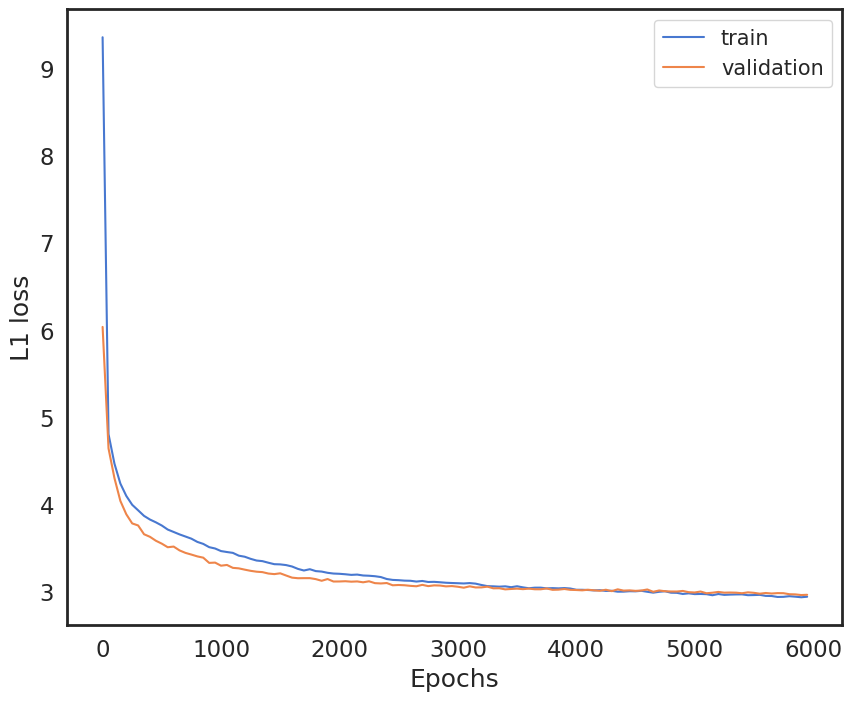

In [15]:
loss_values = {'train' : np.stack(train_loss_values, axis=0),
               'validation' : np.stack(val_loss_values, axis=0)}
loss_plot(epochs, loss_values, plot_test_loss=True, save=False)